In [87]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('OSAS_Iteration4_AyselOoi').getOrCreate()

In [88]:
df = spark.read.load("./survey.csv", format="csv", inferSchema = True, header=True)

In [89]:
#2.2 Description of Data
df.printSchema()
print(df.count(), len(df.columns))

root
 |-- Primary_ID: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- family_history: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- work_interfere: string (nullable = true)
 |-- no_employees: string (nullable = true)
 |-- remote_work: string (nullable = true)
 |-- tech_company: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- care_options: string (nullable = true)
 |-- wellness_program: string (nullable = true)
 |-- seek_help: string (nullable = true)
 |-- anonymity: string (nullable = true)
 |-- leave: string (nullable = true)
 |-- mental_health_consequence: string (nullable = true)
 |-- phys_health_consequence: string (nullable = true)
 |-- coworkers: string (nullable = true)
 |-- supervisor: string (nullable = true)
 |-- ment

In [90]:
df.describe('Age').show()

+-------+--------------------+
|summary|                 Age|
+-------+--------------------+
|  count|                1259|
|   mean| 7.942814831135821E7|
| stddev|2.8182994429819684E9|
|    min|               -1726|
|    max|         99999999999|
+-------+--------------------+



In [91]:
#2.2.3 Data Quality
df.createOrReplaceTempView('survey')
ageResults = spark.sql("SELECT DISTINCT Age FROM survey")
ageResults.show(100, False)

+-----------+
|Age        |
+-----------+
|29         |
|26         |
|65         |
|19         |
|54         |
|-1726      |
|22         |
|34         |
|50         |
|57         |
|32         |
|43         |
|31         |
|39         |
|25         |
|72         |
|58         |
|27         |
|56         |
|51         |
|41         |
|33         |
|28         |
|5          |
|48         |
|44         |
|61         |
|37         |
|55         |
|62         |
|8          |
|99999999999|
|49         |
|11         |
|35         |
|329        |
|36         |
|18         |
|21         |
|38         |
|42         |
|30         |
|23         |
|46         |
|20         |
|60         |
|40         |
|-29        |
|-1         |
|45         |
|47         |
|53         |
|24         |
+-----------+



In [92]:
commentResults = spark.sql("SELECT DISTINCT COUNT(comments) FROM survey WHERE comments = 'NA' or comments = ''")
commentResults.show(100, False)

+---------------+
|count(comments)|
+---------------+
|1095           |
+---------------+



In [93]:
#2.2.4 Coding Schema
genderResults = spark.sql("SELECT DISTINCT Gender FROM survey")
genderResults.show(100, False)

+----------------------------------------------+
|Gender                                        |
+----------------------------------------------+
|non-binary                                    |
|Make                                          |
|F                                             |
|Genderqueer                                   |
|Man                                           |
|Male (CIS)                                    |
|m                                             |
|Female                                        |
|Agender                                       |
|Mal                                           |
|f                                             |
|maile                                         |
|Trans-female                                  |
|Nah                                           |
|Cis Female                                    |
|woman                                         |
|Female                                        |
|Cis Man            

In [94]:
#2.4 Data Quality Verification
# Missing Data
from pyspark.sql.functions import isnan, when, count, col
df.describe().filter(col("summary") == "count").show()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----------+---------+----+------+-------+-----+-------------+--------------+---------+--------------+------------+-----------+------------+--------+------------+----------------+---------+---------+-----+-------------------------+-----------------------+---------+----------+-----------------------+---------------------+------------------+---------------+--------+
|summary|Primary_ID|Timestamp| Age|Gender|Country|state|self_employed|family_history|treatment|work_interfere|no_employees|remote_work|tech_company|benefits|care_options|wellness_program|seek_help|anonymity|leave|mental_health_consequence|phys_health_consequence|coworkers|supervisor|mental_health_interview|phys_health_interview|mental_vs_physical|obs_consequence|comments|
+-------+----------+---------+----+------+-------+-----+-------------+--------------+---------+--------------+------------+-----------+------------+--------+------------+----------------+---------+---------+-----+-------------------------+-----------

In [95]:
#Coding Quality
for col in df.columns:
    print(col, "\t", "with null values: ", df.filter(df[col].isNull()).count())

Primary_ID 	 with null values:  0
Timestamp 	 with null values:  0
Age 	 with null values:  0
Gender 	 with null values:  0
Country 	 with null values:  0
state 	 with null values:  0
self_employed 	 with null values:  0
family_history 	 with null values:  0
treatment 	 with null values:  0
work_interfere 	 with null values:  0
no_employees 	 with null values:  0
remote_work 	 with null values:  0
tech_company 	 with null values:  0
benefits 	 with null values:  0
care_options 	 with null values:  0
wellness_program 	 with null values:  0
seek_help 	 with null values:  0
anonymity 	 with null values:  0
leave 	 with null values:  0
mental_health_consequence 	 with null values:  0
phys_health_consequence 	 with null values:  0
coworkers 	 with null values:  0
supervisor 	 with null values:  0
mental_health_interview 	 with null values:  0
phys_health_interview 	 with null values:  0
mental_vs_physical 	 with null values:  0
obs_consequence 	 with null values:  0
comments 	 with null val

In [96]:
#Search for unique no_employees
noEmployeesResults = spark.sql("SELECT DISTINCT no_employees FROM survey")
noEmployeesResults.show(100, False)

+--------------+
|no_employees  |
+--------------+
|100-500       |
|Jun-25        |
|500-1000      |
|1-May         |
|More than 1000|
|26-100        |
+--------------+



In [97]:
#Data Preparation
#Data Selection
#Selecting Attributes
new_df = df.drop('Timestamp', 'comments', 'state', 'mental_health_interview', 'phys_health_interview')
print(new_df.columns)

['Primary_ID', 'Age', 'Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_vs_physical', 'obs_consequence']


In [98]:
#3.2 Data Cleaning
#3.2.1 Missing Data
#drop any null and missing values
from pyspark.sql.functions import isnan, when, count, col, trim
new_df.printSchema()
new_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in new_df.columns]).show()

def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))

#new_df.select([to_null(c).alias(c) for c in new_df.columns]).na.drop()

for col in new_df.columns:
    print(col, "\t", "with null values: ", new_df.filter(new_df[col].isNull()).count())

root
 |-- Primary_ID: integer (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- family_history: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- work_interfere: string (nullable = true)
 |-- no_employees: string (nullable = true)
 |-- remote_work: string (nullable = true)
 |-- tech_company: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- care_options: string (nullable = true)
 |-- wellness_program: string (nullable = true)
 |-- seek_help: string (nullable = true)
 |-- anonymity: string (nullable = true)
 |-- leave: string (nullable = true)
 |-- mental_health_consequence: string (nullable = true)
 |-- phys_health_consequence: string (nullable = true)
 |-- coworkers: string (nullable = true)
 |-- supervisor: string (nullable = true)
 |-- mental_vs_physical: string (nullable = true)
 |-- obs_consequence: string (nullabl

In [99]:
#3.2.2 Data Error
#condition Age column
import pyspark.sql.functions as f

new_df = new_df.withColumn(
  "Age",
  f.when(
    (f.col("Age") >= 0) & 
    (f.col("Age") <= 95), f.col("Age")).otherwise(f.lit(None))
)

na_df = new_df.dropna()
na_df.select('Age').distinct().show(1000, False)

new_df.describe([ "age" ]).show()

+---+
|Age|
+---+
|29 |
|26 |
|65 |
|19 |
|54 |
|22 |
|34 |
|50 |
|57 |
|32 |
|43 |
|31 |
|39 |
|25 |
|72 |
|58 |
|27 |
|56 |
|51 |
|41 |
|33 |
|28 |
|5  |
|48 |
|44 |
|61 |
|37 |
|55 |
|62 |
|8  |
|49 |
|11 |
|35 |
|36 |
|18 |
|21 |
|38 |
|42 |
|30 |
|23 |
|46 |
|20 |
|60 |
|40 |
|45 |
|47 |
|53 |
|24 |
+---+

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              1254|
|   mean| 32.01913875598086|
| stddev|7.3750047368256935|
|    min|                 5|
|    max|                72|
+-------+------------------+



In [100]:
na_df.select('Gender').distinct().show()

+------------+
|      Gender|
+------------+
|  non-binary|
|        Make|
|           F|
| Genderqueer|
|         Man|
|  Male (CIS)|
|           m|
|     Female |
|     Agender|
|         Mal|
|           f|
|       maile|
|Trans-female|
|         Nah|
|  Cis Female|
|       woman|
|      Female|
|     Cis Man|
|      female|
|           M|
+------------+
only showing top 20 rows



In [101]:
#recategorizing gender into appropriate column
from pyspark.sql.functions import lower, col, udf
import pyspark.sql.functions as f 

na_df = na_df.withColumn('Gender', lower(col('Gender')))

Male = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man", "msle", "mail", "malr","cis man", "cis male"]
Female = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail", "trans-female",  "trans woman", "female (trans)"]
Other = ["non-binary", "nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "neuter", "queer", "ostensibly male, unsure what that really means", "queer/she/they", "something kinda male?", "a little about you", "p"]

na_df2 = na_df.withColumn('Gender',f.when(f.col('Gender').isin(Male),f.lit('Male')).\
when(f.col('Gender').isin(Other),f.lit('Other')).\
when(f.col('Gender').isin(Female),f.lit('Female')).\
otherwise(f.col('Gender')))


na_df2.select('Gender').distinct().show()

+------+
|Gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [102]:
#3.3 Data Construction
#3.3.1 Deriving Attributes
#treatment and work_interfere condition met
na_df2 = na_df.withColumn('mental_issue_in_tech', (f.col('treatment') == 'Yes') & (f.col('work_interfere') == 'Often'))
na_df2.select('mental_issue_in_tech').show()

+--------------------+
|mental_issue_in_tech|
+--------------------+
|                true|
|               false|
|               false|
|                true|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
+--------------------+
only showing top 20 rows



In [103]:
#3.4 Data Integration
#3.4.1 Merging Data
df1 = spark.read.load("./Survey1.csv", format="csv", inferSchema = True, header=True)
df2 = spark.read.load("./Survey2.csv", format="csv", inferSchema = True, header=True)
first = df1.select('Primary_ID', 'Age', 'Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options')
second = df2.select('Primary_ID','wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_vs_physical', 'obs_consequence')
result = first.join(second, on=['Primary_ID'], how='inner')

In [104]:
result = result.drop('Timestamp', 'comments', 'state', 'mental_health_interview', 'phys_health_interview')

result = result.withColumn('mental_issue_in_tech', (f.col('treatment') == 'Yes') & (f.col('work_interfere') == 'Often'))
result.select('mental_issue_in_tech').show()

from pyspark.sql.types import StringType
result = result.withColumn("mental_issue_in_tech", result["mental_issue_in_tech"].cast(StringType()))

+--------------------+
|mental_issue_in_tech|
+--------------------+
|                true|
|               false|
|               false|
|                true|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
|               false|
+--------------------+
only showing top 20 rows



In [105]:
import pyspark.sql.functions as f
from pyspark.sql.functions import asc

result = result.withColumn(
  "Age",
  f.when(
    (f.col("Age") >= 0) & 
    (f.col("Age") <= 95), f.col("Age")).otherwise(f.lit(None))
)

result = result.dropna()
result.select('Age').distinct().show(1000, False)
result.groupby('Age').count().sort(col("count").asc()).show(1000, False)

+---+
|Age|
+---+
|29 |
|26 |
|65 |
|19 |
|54 |
|22 |
|34 |
|50 |
|57 |
|32 |
|43 |
|31 |
|39 |
|25 |
|72 |
|58 |
|27 |
|56 |
|51 |
|41 |
|33 |
|28 |
|5  |
|48 |
|44 |
|61 |
|37 |
|55 |
|62 |
|8  |
|49 |
|11 |
|35 |
|36 |
|18 |
|21 |
|38 |
|42 |
|30 |
|23 |
|46 |
|20 |
|60 |
|40 |
|45 |
|47 |
|53 |
|24 |
+---+

+---+-----+
|Age|count|
+---+-----+
|61 |1    |
|62 |1    |
|8  |1    |
|72 |1    |
|11 |1    |
|58 |1    |
|53 |1    |
|5  |1    |
|65 |1    |
|47 |2    |
|60 |2    |
|55 |3    |
|57 |3    |
|54 |3    |
|49 |4    |
|56 |4    |
|51 |5    |
|48 |6    |
|50 |6    |
|20 |6    |
|18 |7    |
|19 |9    |
|44 |11   |
|46 |12   |
|45 |12   |
|21 |16   |
|42 |20   |
|22 |21   |
|41 |21   |
|43 |28   |
|40 |33   |
|39 |33   |
|36 |37   |
|38 |39   |
|37 |43   |
|24 |46   |
|23 |51   |
|35 |55   |
|25 |61   |
|30 |63   |
|34 |65   |
|31 |67   |
|28 |68   |
|33 |70   |
|27 |71   |
|26 |75   |
|32 |82   |
|29 |85   |
+---+-----+



In [106]:
#3.5  Data Formating
#Removing comma from the column
from pyspark.sql.functions import *
result = result.withColumn('Country', regexp_replace('Country', ',', ''))
result.select('Country').distinct().show(1000,  False)

+----------------------+
|Country               |
+----------------------+
|Russia                |
|Bahamas The           |
|Sweden                |
|Philippines           |
|Singapore             |
|Germany               |
|France                |
|Greece                |
|Belgium               |
|Finland               |
|United States         |
|India                 |
|China                 |
|Croatia               |
|Nigeria               |
|Italy                 |
|Norway                |
|Spain                 |
|Denmark               |
|Ireland               |
|Thailand              |
|Israel                |
|Uruguay               |
|Mexico                |
|Georgia               |
|Switzerland           |
|Latvia                |
|Canada                |
|Czech Republic        |
|Brazil                |
|Slovenia              |
|Japan                 |
|New Zealand           |
|Bosnia and Herzegovina|
|Poland                |
|Portugal              |
|Australia             |


In [107]:
result = result.withColumn("work_interfere", f.when(f.col("work_interfere")=='NA', 'Never').otherwise(f.col("work_interfere")))
result.select('work_interfere').distinct().show()

+--------------+
|work_interfere|
+--------------+
|     Sometimes|
|        Rarely|
|         Often|
|         Never|
+--------------+



In [108]:
from pyspark.sql.functions import lower, col, udf
import pyspark.sql.functions as f 

result = result.withColumn('Gender', lower(col('Gender')))

Male = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man", "msle", "mail", "malr","cis man", "cis male"]
Female = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail", "trans-female",  "trans woman", "female (trans)"]
Other = ["non-binary", "nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "neuter", "queer", "ostensibly male, unsure what that really means", "queer/she/they", "something kinda male?", "a little about you", "p"]

result = result.withColumn('Gender',f.when(f.col('Gender').isin(Male),f.lit('Male')).\
when(f.col('Gender').isin(Other),f.lit('Other')).\
when(f.col('Gender').isin(Female),f.lit('Female')).\
otherwise(f.col('Gender')))

result.select('Gender').distinct().show()

+------+
|Gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [109]:
#Labeling columns
new_result = result

new_result = new_result.withColumn('Gender',f.when(f.col('Gender')== 'Male',f.lit(0)).\
when(f.col('Gender')== 'Female',f.lit(1)).\
when(f.col('Gender')== 'Other',f.lit(2)).\
otherwise(f.col('Gender')))


new_result = new_result.withColumn('Country',f.when(f.col('Country')== 'Russia',f.lit(0)).\
when(f.col('Country')== 'Bahamas The',f.lit(1)).\
when(f.col('Country')== 'Sweden',f.lit(2)).\
when(f.col('Country')== 'Philippines',f.lit(3)).\
when(f.col('Country')== 'Singapore',f.lit(4)).\
when(f.col('Country')== 'Germany',f.lit(5)).\
when(f.col('Country')== 'France',f.lit(6)).\
when(f.col('Country')== 'Greece',f.lit(7)).\
when(f.col('Country')== 'Belgium',f.lit(8)).\
when(f.col('Country')== 'Finland',f.lit(9)).\
when(f.col('Country')== 'United States',f.lit(10)).\
when(f.col('Country')== 'India',f.lit(11)).\
when(f.col('Country')== 'China',f.lit(12)).\
when(f.col('Country')== 'Croatia',f.lit(13)).\
when(f.col('Country')== 'Nigeria',f.lit(14)).\
when(f.col('Country')== 'Italy',f.lit(15)).\
when(f.col('Country')== 'Norway',f.lit(16)).\
when(f.col('Country')== 'Spain',f.lit(17)).\
when(f.col('Country')== 'Denmark',f.lit(18)).\
when(f.col('Country')== 'Ireland',f.lit(19)).\
when(f.col('Country')== 'Thailand',f.lit(20)).\
when(f.col('Country')== 'Israel',f.lit(21)).\
when(f.col('Country')== 'Uruguay',f.lit(22)).\
when(f.col('Country')== 'Mexico',f.lit(23)).\
when(f.col('Country')== 'Georgia',f.lit(24)).\
when(f.col('Country')== 'Switzerland',f.lit(25)).\
when(f.col('Country')== 'Latvia',f.lit(26)).\
when(f.col('Country')== 'Canada',f.lit(27)).\
when(f.col('Country')== 'Czech Republic',f.lit(28)).\
when(f.col('Country')== 'Brazil',f.lit(29)).\
when(f.col('Country')== 'Slovenia',f.lit(30)).\
when(f.col('Country')== 'Japan',f.lit(31)).\
when(f.col('Country')== 'New Zealand',f.lit(32)).\
when(f.col('Country')== 'Bosnia and Herzegovina',f.lit(33)).\
when(f.col('Country')== 'Poland',f.lit(34)).\
when(f.col('Country')== 'Portugal',f.lit(35)).\
when(f.col('Country')== 'Australia',f.lit(36)).\
when(f.col('Country')== 'Romania',f.lit(37)).\
when(f.col('Country')== 'Bulgaria',f.lit(38)).\
when(f.col('Country')== 'Austria',f.lit(39)).\
when(f.col('Country')== 'Costa Rica',f.lit(40)).\
when(f.col('Country')== 'South Africa',f.lit(41)).\
when(f.col('Country')== 'Colombia',f.lit(42)).\
when(f.col('Country')== 'Hungary',f.lit(43)).\
when(f.col('Country')== 'United Kingdom',f.lit(44)).\
when(f.col('Country')== 'Moldova',f.lit(45)).\
when(f.col('Country')== 'Netherlands',f.lit(46)).\
otherwise(f.col('Country')))


new_result = new_result.withColumn('self_employed',f.when(f.col('self_employed')== 'NA',f.lit(0)).\
when(f.col('self_employed')== 'No',f.lit(1)).\
when(f.col('self_employed')== 'Yes',f.lit(2)).\
otherwise(f.col('self_employed')))


new_result = new_result.withColumn('family_history',f.when(f.col('family_history')== 'No',f.lit(0)).\
when(f.col('family_history')== 'Yes',f.lit(1)).\
otherwise(f.col('family_history')))


new_result = new_result.withColumn('treatment',f.when(f.col('treatment')== 'No',f.lit(0)).\
when(f.col('treatment')== 'Yes',f.lit(1)).\
otherwise(f.col('treatment')))


new_result = new_result.withColumn('work_interfere',f.when(f.col('work_interfere')== 'Sometimes',f.lit(2)).\
when(f.col('work_interfere')== 'Rarely',f.lit(1)).\
when(f.col('work_interfere')== 'Often',f.lit(3)).\
when(f.col('work_interfere')== 'Never',f.lit(0)).\
otherwise(f.col('work_interfere')))


new_result = new_result.withColumn('remote_work',f.when(f.col('remote_work')== 'No',f.lit(0)).\
when(f.col('remote_work')== 'Yes',f.lit(1)).\
otherwise(f.col('remote_work')))


new_result = new_result.withColumn('tech_company',f.when(f.col('tech_company')== 'No',f.lit(0)).\
when(f.col('tech_company')== 'Yes',f.lit(1)).\
otherwise(f.col('tech_company')))


new_result = new_result.withColumn('benefits',f.when(f.col('benefits')== 'No',f.lit(0)).\
when(f.col('benefits')== 'Yes',f.lit(1)).\
when(f.col('benefits')== "Don't know",f.lit(2)).\
otherwise(f.col('benefits')))


new_result = new_result.withColumn('care_options',f.when(f.col('care_options')== 'No',f.lit(0)).\
when(f.col('care_options')== 'Yes',f.lit(1)).\
when(f.col('care_options')== "Not sure",f.lit(2)).\
otherwise(f.col('care_options')))


new_result = new_result.withColumn('wellness_program',f.when(f.col('wellness_program')== 'No',f.lit(0)).\
when(f.col('wellness_program')== 'Yes',f.lit(1)).\
when(f.col('wellness_program')== "Don't know",f.lit(2)).\
otherwise(f.col('wellness_program')))


new_result = new_result.withColumn('seek_help',f.when(f.col('seek_help')== 'No',f.lit(0)).\
when(f.col('seek_help')== 'Yes',f.lit(1)).\
when(f.col('seek_help')== "Don't know",f.lit(2)).\
otherwise(f.col('seek_help')))


new_result = new_result.withColumn('anonymity',f.when(f.col('anonymity')== 'No',f.lit(0)).\
when(f.col('anonymity')== 'Yes',f.lit(1)).\
when(f.col('anonymity')== "Don't know",f.lit(2)).\
otherwise(f.col('anonymity')))


new_result = new_result.withColumn('leave',f.when(f.col('leave')== 'Somewhat difficult',f.lit(0)).\
when(f.col('leave')== 'Somewhat easy',f.lit(1)).\
when(f.col('leave')== "Don't know",f.lit(2)).\
when(f.col('leave')== "Very difficult",f.lit(3)).\
when(f.col('leave')== "Very easy",f.lit(4)).\
otherwise(f.col('leave')))


new_result = new_result.withColumn('mental_health_consequence',f.when(f.col('mental_health_consequence')== 'No',f.lit(0)).\
when(f.col('mental_health_consequence')== 'Yes',f.lit(1)).\
when(f.col('mental_health_consequence')== "Maybe",f.lit(2)).\
otherwise(f.col('mental_health_consequence')))


new_result = new_result.withColumn('phys_health_consequence',f.when(f.col('phys_health_consequence')== 'No',f.lit(0)).\
when(f.col('phys_health_consequence')== 'Yes',f.lit(1)).\
when(f.col('phys_health_consequence')== "Maybe",f.lit(2)).\
otherwise(f.col('phys_health_consequence')))


new_result = new_result.withColumn('coworkers',f.when(f.col('coworkers')== 'No',f.lit(0)).\
when(f.col('coworkers')== 'Yes',f.lit(1)).\
when(f.col('coworkers')== "Some of them",f.lit(2)).\
otherwise(f.col('coworkers')))


new_result = new_result.withColumn('supervisor',f.when(f.col('supervisor')== 'No',f.lit(0)).\
when(f.col('supervisor')== 'Yes',f.lit(1)).\
when(f.col('supervisor')== "Some of them",f.lit(2)).\
otherwise(f.col('supervisor')))


new_result = new_result.withColumn('mental_vs_physical',f.when(f.col('mental_vs_physical')== 'No',f.lit(0)).\
when(f.col('mental_vs_physical')== 'Yes',f.lit(1)).\
when(f.col('mental_vs_physical')== "Don't know",f.lit(2)).\
otherwise(f.col('mental_vs_physical')))


new_result = new_result.withColumn('obs_consequence',f.when(f.col('obs_consequence')== 'No',f.lit(0)).\
when(f.col('obs_consequence')== 'Yes',f.lit(1)).\
otherwise(f.col('obs_consequence')))


new_result = new_result.withColumn('mental_issue_in_tech',f.when(f.col('mental_issue_in_tech')== False, 0).otherwise(1))

new_result = new_result.withColumn('no_employees',f.when(f.col('no_employees')== '100-500',f.lit(0)).\
when(f.col('no_employees')== 'Jun-25',f.lit(1)).\
when(f.col('no_employees')== "500-1000",f.lit(2)).\
when(f.col('no_employees')== "1-May",f.lit(3)).\
when(f.col('no_employees')== "More than 1000",f.lit(4)).\
when(f.col('no_employees')== "26-100",f.lit(5)).\
otherwise(f.col('no_employees')))

new_result.printSchema()

root
 |-- Primary_ID: integer (nullable = true)
 |-- Age: long (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- family_history: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- work_interfere: string (nullable = true)
 |-- no_employees: string (nullable = true)
 |-- remote_work: string (nullable = true)
 |-- tech_company: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- care_options: string (nullable = true)
 |-- wellness_program: string (nullable = true)
 |-- seek_help: string (nullable = true)
 |-- anonymity: string (nullable = true)
 |-- leave: string (nullable = true)
 |-- mental_health_consequence: string (nullable = true)
 |-- phys_health_consequence: string (nullable = true)
 |-- coworkers: string (nullable = true)
 |-- supervisor: string (nullable = true)
 |-- mental_vs_physical: string (nullable = true)
 |-- obs_consequence: string (nullabl

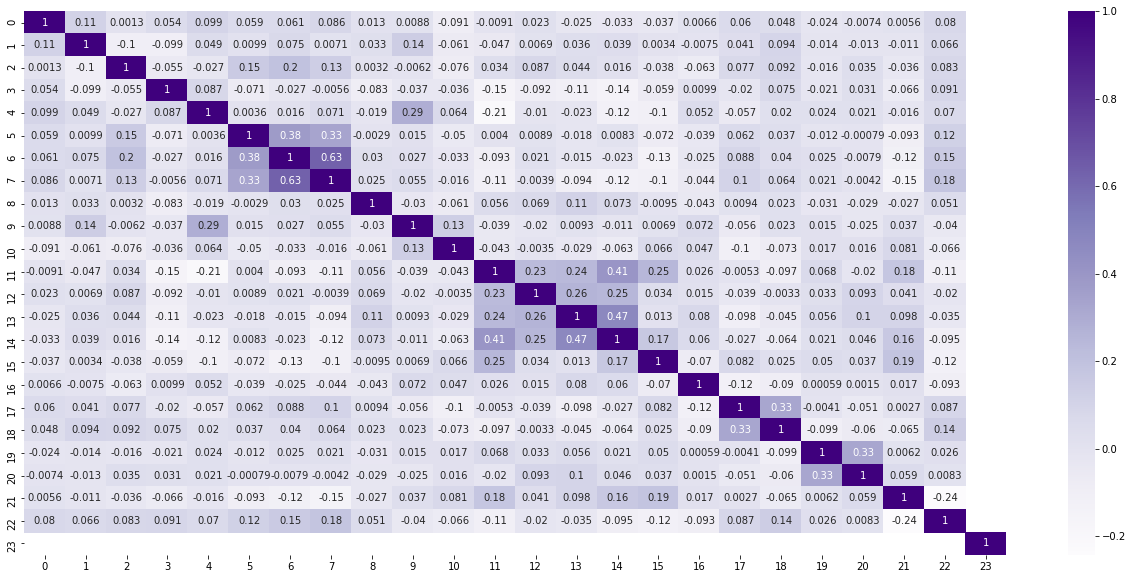

In [110]:
#4 Data Transformation
#4.1 Data Reduction - Correlation matrix with Heatmap
from pyspark.mllib.stat import Statistics
from pyspark import SparkContext, SparkConf
import seaborn as sns
import matplotlib.pyplot as plt
conf = SparkConf().setAppName('OSAS_Iteration4_AyselOoi').setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

resultRDD = new_result.rdd.map(lambda row: row[0:])
corrlation_matrix = Statistics.corr(resultRDD, method = 'pearson')
rdd0 = sc.parallelize(corrlation_matrix)
rdd1 = rdd0.map(lambda x: [float(i) for i in x])
corrlation_matrix[1]

plt.figure(figsize=(22,10))
sns.heatmap(corrlation_matrix, cmap="Purples", annot = True)
plt.show()

In [111]:
result = result.drop('self_employed', 'remote_work', 'tech_company', 'wellness_program', 'seek_help', 'mental_health_consequence', 'phys_health_consequence', 'supervisor', 'mental_vs_physical', 'obs_consequence', 'no_employees')

In [112]:
#Convert columns and transform them to numerical
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

column_vec_in = ['Primary_ID',
             'Age',
             'Gender',
             'Country',
             'family_history',
             'work_interfere',
             'benefits',
             'care_options',
             'anonymity',
             'leave',
             'coworkers',
             'mental_issue_in_tech']

column_vec_out = ['Primary_ID_Vec',
             'Age_Vec',
             'Gender_Vec',
             'Country_Vec',
             'family_history_Vec',
             'work_interfere_Vec',
             'benefits_Vec',
             'care_options_Vec',
             'anonymity_Vec',
             'leave_Vec',
             'coworkers_Vec',
             'mental_issue_in_tech_Vec']

indexers = [StringIndexer(inputCol = x, outputCol=x + "_tmp") for x in column_vec_in]

encoders = [OneHotEncoder(dropLast=False, inputCol = x + "_tmp", outputCol = y)
           for x, y in zip(column_vec_in, column_vec_out)]

tmp = [[i, j] for i, j in zip(indexers, encoders)]
tmp = [i for sublist in tmp for i in sublist]

In [113]:
#combining atttributes into the of features and target is treatment
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

cols_now = ['Primary_ID_Vec',
             'Age_Vec',
             'Gender_Vec',
             'Country_Vec',
             'family_history_Vec',
             'work_interfere_Vec',
             'benefits_Vec',
             'care_options_Vec',
             'anonymity_Vec',
             'leave_Vec',
             'coworkers_Vec',
             'mental_issue_in_tech_Vec']

assembler_features = VectorAssembler(inputCols = cols_now, outputCol= "features")
labelIndexer = StringIndexer(inputCol = 'treatment', outputCol= "label")
tmp += [assembler_features, labelIndexer]
pipeline = Pipeline(stages = tmp)

In [114]:
from pyspark.sql.types import *

def categorizer(Age):
  if Age < 10 and Age < 20:
    return "0"
  elif Age < 30 and Age < 40:
    return "1"
  elif Age < 50 and Age < 60:
    return "2"
  elif Age < 70 and Age < 80:
    return "3"
  else: 
    return "4"

bucket_udf = udf(categorizer, StringType())
result = result.withColumn("Age_binning", bucket_udf("Age"))

result.select('Age_binning').show(1000,  False)

+-----------+
|Age_binning|
+-----------+
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|1          |
|2          |
|1          |
|2          |
|2          |
|1          |
|1          |
|1          |
|2          |
|2          |
|2          |
|1          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|2          |
|1          |
|1          |
|2          |
|3          |
|2          |
|1          |
|2          |
|1          |
|1          |
|2          |
|2          |
|1          |
|2          |
|1          |
|2          |
|1          |
|2          |
|2          |
|2          |
|1          |
|1          |
|2          |
|1          |
|1          |
|2          |
|2          |
|1          |
|1          |
|1          |
|2          |
|2          |
|1          |
|2          |
|2    

In [115]:
#Training Data split 70% and 30%
allData = pipeline.fit(new_result).transform(new_result)
allData.cache()

trainingData, testData = allData.randomSplit([0.7, 0.3], seed=0)
print("Distribution of Positive and Negative in trainingData is: ", trainingData.groupBy("label").count().take(3))

Distribution of Positive and Negative in trainingData is:  [Row(label=0.0, count=454), Row(label=1.0, count=439)]


In [116]:
#Random Forest Classifer
from pyspark.ml.classification import RandomForestClassifier as RF
rf = RF(labelCol = "label", featuresCol = "features", numTrees = 200, maxDepth = 3)
fit = rf.fit(trainingData)
transformed = fit.transform(testData)

fit.featureImportances

SparseVector(1376, {2: 0.0002, 6: 0.0011, 10: 0.0001, 11: 0.0016, 22: 0.0001, 24: 0.0, 27: 0.0004, 33: 0.0007, 35: 0.0005, 37: 0.0012, 38: 0.0012, 39: 0.0001, 41: 0.0003, 43: 0.0013, 44: 0.0016, 56: 0.0017, 66: 0.0001, 75: 0.0002, 77: 0.0, 81: 0.0005, 83: 0.0003, 84: 0.0, 86: 0.0007, 87: 0.0016, 91: 0.0002, 102: 0.0004, 103: 0.0, 104: 0.0018, 113: 0.0017, 116: 0.0013, 120: 0.0003, 122: 0.0017, 125: 0.0017, 129: 0.0001, 134: 0.0001, 143: 0.0003, 150: 0.0, 167: 0.0003, 173: 0.0007, 176: 0.0003, 178: 0.0014, 181: 0.0005, 183: 0.0021, 190: 0.0003, 196: 0.0, 199: 0.0003, 200: 0.0016, 201: 0.0002, 203: 0.0001, 204: 0.0002, 205: 0.0, 206: 0.0001, 209: 0.0009, 210: 0.0017, 213: 0.0001, 215: 0.0002, 219: 0.0, 220: 0.0004, 227: 0.0016, 248: 0.0002, 249: 0.0005, 254: 0.0003, 262: 0.0002, 266: 0.0011, 267: 0.0006, 275: 0.0003, 276: 0.0002, 289: 0.0003, 290: 0.0002, 291: 0.0001, 292: 0.0017, 293: 0.0009, 296: 0.0017, 299: 0.0001, 314: 0.0012, 315: 0.0001, 321: 0.001, 323: 0.0002, 327: 0.0003, 334: 

In [117]:
#Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier as DT
tree = DT(labelCol = "label", featuresCol = "features", maxDepth = 3)
tree_fit = tree.fit(trainingData)
tree_transformed = tree_fit.transform(testData)

tree_fit.featureImportances

SparseVector(1376, {84: 0.0075, 113: 0.0075, 1352: 0.0541, 1354: 0.8874, 1358: 0.0342, 1362: 0.0093})

In [118]:
#6.3.2 Random Forest
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('OSAS_Iteration4_AyselOoi').setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

results = transformed.select(['probability', 'label'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

scoreAndLabels = sc.parallelize(results_list)
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

from sklearn.metrics import classification_report, confusion_matrix
y_true = transformed.select(['label']).collect()
y_pred = transformed.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

The ROC score is:  0.8863343360550077
Area under PR = 0.8587136647793727
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       179
         1.0       0.86      0.80      0.83       182

    accuracy                           0.83       361
   macro avg       0.84      0.83      0.83       361
weighted avg       0.84      0.83      0.83       361



In [119]:
#6.3.1 Decision Tree
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('OSAS_Iteration4_AyselOoi').setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

tree_results = tree_transformed.select(['probability', 'label'])

tree_results_collect = tree_results.collect()
tree_results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in tree_results_collect]

tree_scoreAndLabels = sc.parallelize(tree_results_list)
tree_metrics = metric(tree_scoreAndLabels)
print("The ROC score is: ", tree_metrics.areaUnderROC)
# Area under precision-recall curve
print("Area under PR = %s" % tree_metrics.areaUnderPR)

from sklearn.metrics import classification_report, confusion_matrix
y_true = tree_transformed.select(['label']).collect()
y_pred = tree_transformed.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

The ROC score is:  0.8729664190558045
Area under PR = 0.8546944585697565
              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85       179
         1.0       0.93      0.72      0.81       182

    accuracy                           0.83       361
   macro avg       0.85      0.83      0.83       361
weighted avg       0.85      0.83      0.83       361



In [120]:
#7 Data Mining
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline

dtc = DecisionTreeClassifier(labelCol='label',featuresCol='features')
rfc = RandomForestClassifier(labelCol='label',featuresCol='features')
gbt = GBTClassifier(labelCol='label',featuresCol='features')
nb = NaiveBayes(labelCol='label',featuresCol='features')

dtc_model = dtc.fit(trainingData)
rfc_model = rfc.fit(trainingData)
gbt_model = gbt.fit(trainingData)
nb_model = nb.fit(trainingData)

dtc_predictions = dtc_model.transform(testData)
rfc_predictions = rfc_model.transform(testData)
gbt_predictions = gbt_model.transform(testData)
nb_predictions = nb_model.transform(testData)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_binary_eval = BinaryClassificationEvaluator(labelCol = 'label')
print("Decision Tree Classifier")
print(my_binary_eval.evaluate(dtc_predictions))

print("Random Forest Classifer")
print(my_binary_eval.evaluate(rfc_predictions))

my_binary_gbt_eval = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction')
print("Gradient-Boosted Trees")
print(my_binary_gbt_eval.evaluate(gbt_predictions))

print("Naive Bayes")
print(my_binary_gbt_eval.evaluate(nb_predictions))

Decision Tree Classifier
0.8619774080667935
Random Forest Classifer
0.876711277549265
Gradient-Boosted Trees
0.8287955061698078
Naive Bayes
0.8145067223279514


In [121]:
#7.2 Conduct Data Mining
#Evaluating Accuracy for all test model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
gbt_acc = acc_evaluator.evaluate(gbt_predictions)
nb_acc = acc_evaluator.evaluate(nb_predictions)

print("Here are the results!")
print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*40)
print('An ensemble using gradient-boosted trees has an accuracy of: {0:2.2f}%'.format(gbt_acc*100))
print('-'*40)
print('An ensemble using Naive Bayes has an accuracy of: {0:2.2f}%'.format(nb_acc*100))

Here are the results!
----------------------------------------
A single decision tree has an accuracy of: 82.83%
----------------------------------------
A random forest ensemble has an accuracy of: 82.55%
----------------------------------------
An ensemble using gradient-boosted trees has an accuracy of: 82.83%
----------------------------------------
An ensemble using Naive Bayes has an accuracy of: 81.44%


In [122]:
#Decision Tree Features Important
from pyspark.ml.regression import DecisionTreeRegressor as DTR
dtr_tree = DTR(labelCol = "label", featuresCol = "features", maxDepth = 3)
dtr_tree_fit = dtr_tree.fit(trainingData)
dtr_tree_transformed = dtr_tree_fit.transform(testData)

dtr_tree_fit.featureImportances

SparseVector(1376, {84: 0.0075, 113: 0.0075, 1352: 0.0541, 1354: 0.8874, 1358: 0.0342, 1362: 0.0093})

In [123]:
from pyspark.mllib.evaluation import RegressionMetrics as metric
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('OSAS_Iteration4_AyselOoi').setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

dtr_results = dtr_tree_transformed.select(['features', 'label'])

dtr_results_collect = dtr_results.collect()
dtr_results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in dtr_results_collect]

dtr_scoreAndLabels = sc.parallelize(dtr_results_list)
dtr_metrics = metric(dtr_scoreAndLabels)
print("Mean Absolute Error is: ", dtr_metrics.meanAbsoluteError)
print("Mean Squared Error: ", dtr_metrics.meanSquaredError)
print("Root Mean Squared Error is: ", dtr_metrics.rootMeanSquaredError)
print("R2 is: ", dtr_metrics.r2)
print("Explained Variance is: ", dtr_metrics.explainedVariance)

Mean Absolute Error is:  0.49584487534626037
Mean Squared Error:  0.49584487534626037
Root Mean Squared Error is:  0.7041625347505079
R2 is:  -0.9835164835164836
Explained Variance is:  0.24586214040714996


In [124]:
#Random Forest Feature Importances
from pyspark.ml.regression import RandomForestRegressor as RFR
rfr_tree = RFR(labelCol = "label", featuresCol = "features", maxDepth = 3)
rfr_tree_fit = rfr_tree.fit(trainingData)
rfr_tree_transformed = rfr_tree_fit.transform(testData)

rfr_tree_fit.featureImportances

SparseVector(1376, {115: 0.0009, 133: 0.0019, 161: 0.0007, 193: 0.0008, 291: 0.0011, 497: 0.0035, 525: 0.0034, 537: 0.0016, 551: 0.001, 560: 0.0008, 630: 0.0008, 698: 0.0018, 700: 0.0007, 782: 0.0012, 849: 0.0012, 866: 0.0014, 869: 0.0013, 961: 0.001, 977: 0.0019, 985: 0.0007, 990: 0.0008, 1004: 0.0023, 1216: 0.0017, 1261: 0.0013, 1262: 0.0012, 1267: 0.0005, 1272: 0.0011, 1276: 0.0008, 1277: 0.0008, 1283: 0.0007, 1284: 0.0005, 1302: 0.0149, 1303: 0.001, 1307: 0.0006, 1309: 0.0006, 1310: 0.0007, 1311: 0.0028, 1317: 0.0007, 1352: 0.0982, 1353: 0.0623, 1354: 0.5038, 1355: 0.1521, 1356: 0.0339, 1357: 0.0216, 1358: 0.0137, 1359: 0.0112, 1361: 0.0014, 1362: 0.0384, 1370: 0.0023})

In [125]:
#Conduct Data Mining
from pyspark.mllib.evaluation import RegressionMetrics as metric
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('OSAS_Iteration4_AyselOoi').setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

rfr_results = rfr_tree_transformed.select(['features', 'label'])

rfr_results_collect = rfr_results.collect()
rfr_results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in rfr_results_collect]

rfr_scoreAndLabels = sc.parallelize(rfr_results_list)
rfr_metrics = metric(rfr_scoreAndLabels)
print("Mean Absolute Error is: ", rfr_metrics.meanAbsoluteError)
print("Mean Squared Error: ", rfr_metrics.meanSquaredError)
print("Root Mean Squared Error is: ", rfr_metrics.rootMeanSquaredError)
print("R2 is: ", rfr_metrics.r2)
print("Explained Variance is: ", rfr_metrics.explainedVariance)

Mean Absolute Error is:  0.49584487534626037
Mean Squared Error:  0.49584487534626037
Root Mean Squared Error is:  0.7041625347505079
R2 is:  -0.9835164835164836
Explained Variance is:  0.24586214040714996


In [127]:
allData = allData.drop('self_employed', 'remote_work', 'tech_company', 'wellness_program', 'seek_help', 'mental_health_consequence', 'phys_health_consequence', 'supervisor', 'mental_vs_physical', 'obs_consequence', 'no_employees', 'Age_binning', 'Age_binning_encoded', 'self_employed_tmp', 'remote_work_tmp', 'tech_company_tmp', 'wellness_program_tmp', 'seek_help_tmp', 'mental_health_consequence_tmp', 'phys_health_consequence_tmp', 'supervisor_tmp', 'mental_vs_physical_tmp', 'obs_consequence_tmp', 'no_employees_tmp', 'Age_binning_tmp', 'Age_binning_encoded_tmp', 'self_employed_Vec', 'remote_work_Vec', 'tech_company_Vec', 'wellness_program_Vec', 'seek_help_Vec', 'mental_health_consequence_Vec', 'phys_health_consequence_Vec', 'supervisor_Vec', 'mental_vs_physical_Vec', 'obs_consequence_Vec', 'no_employees_Vec', 'Age_binning_Vec', 'Age_binning_encoded_Vec')

In [128]:
from pyspark.ml.feature import ChiSqSelector as CSS
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('OSAS_Iteration4_AyselOoi').setMaster("local[*]")
sc = SparkContext.getOrCreate(conf)

selector = CSS(numTopFeatures=10, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="label")
selector_result = selector.fit(allData)
selector_transformed = selector_result.transform(allData)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
selector_transformed.show(10)

ChiSqSelector output with top 10 features selected
+----------+---+------+-------+--------------+---------+--------------+--------+------------+---------+-----+---------+--------------------+--------------+-------------------+-------+---------------+----------+-------------+-----------+--------------+------------------+------------------+------------------+------------------+------------+-------------+----------------+----------------+-------------+-------------+---------+-------------+-------------+-------------+------------------------+------------------------+--------------------+-----+--------------------+
|Primary_ID|Age|Gender|Country|family_history|treatment|work_interfere|benefits|care_options|anonymity|leave|coworkers|mental_issue_in_tech|Primary_ID_tmp|     Primary_ID_Vec|Age_tmp|        Age_Vec|Gender_tmp|   Gender_Vec|Country_tmp|   Country_Vec|family_history_tmp|family_history_Vec|work_interfere_tmp|work_interfere_Vec|benefits_tmp| benefits_Vec|care_options_tmp|care_option

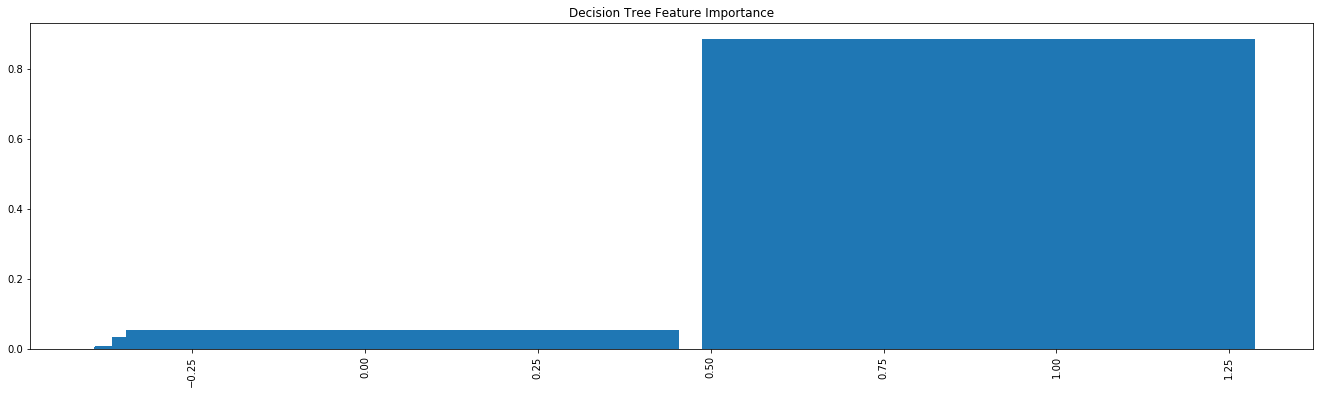

In [103]:
#Decision Tree Features Important
from pyspark.ml.regression import DecisionTreeRegressor as DTR
dtr_tree = DTR(labelCol = "label", featuresCol = "features", maxDepth = 3)
dtr_tree_fit = dtr_tree.fit(trainingData)
dtr_tree_transformed = dtr_tree_fit.transform(testData)

dtr_tree_fit.featureImportances

plt.figure(figsize=(23,6))
plt.bar('label', dtr_tree_fit.featureImportances)
plt.xticks(rotation=90)
plt.title('Decision Tree Feature Importance')
plt.show(5)

#Random Forest Feature Importances
from pyspark.ml.regression import RandomForestRegressor as RFR
rfr_tree = RFR(labelCol = "label", featuresCol = "features", maxDepth = 3)
rfr_tree_fit = rfr_tree.fit(trainingData)
rfr_tree_transformed = rfr_tree_fit.transform(testData)

rfr_tree_fit.featureImportances

plt.figure(figsize=(23,6))
plt.bar('label', rfr_tree_fit.featureImportances)
plt.xticks(rotation=90)
plt.title('Random Forest Feature Importance')
plt.show(5)

In [43]:
feature_name = ['Primary_ID',
             'Age',
             'Gender',
             'Country',
             'family_history',
             'work_interfere',
             'benefits',
             'care_options',
             'anonymity',
             'leave',
             'coworkers',
             'mental_issue_in_tech']

print(dtc_model.toDebugString)

index = 0 
for feature in feature_name:
    print(' feature ' + str(index) + " : " + feature_name[index])
    index += 1

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_43d899bdb6db9c1bec9d) of depth 5 with 39 nodes
  If (feature 1354 in {0.0})
   If (feature 1352 in {0.0})
    If (feature 1362 in {1.0})
     If (feature 193 in {1.0})
      Predict: 1.0
     Else (feature 193 not in {1.0})
      If (feature 213 in {1.0})
       Predict: 1.0
      Else (feature 213 not in {1.0})
       Predict: 0.0
    Else (feature 1362 not in {1.0})
     If (feature 1368 in {1.0})
      If (feature 176 in {1.0})
       Predict: 1.0
      Else (feature 176 not in {1.0})
       Predict: 0.0
     Else (feature 1368 not in {1.0})
      If (feature 1271 in {1.0})
       Predict: 1.0
      Else (feature 1271 not in {1.0})
       Predict: 0.0
   Else (feature 1352 not in {0.0})
    If (feature 1358 in {1.0})
     If (feature 1363 in {1.0})
      If (feature 1357 in {1.0})
       Predict: 0.0
      Else (feature 1357 not in {1.0})
       Predict: 1.0
     Else (feature 1363 not in {1.0})
      If (feature 1266 in {1